<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_3_conv_VAE_latent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from IPython.display import clear_output

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
])

# load the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False,
                                  download=True, transform=transform)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
batch_size = 2048
epochs = 100
learning_rate = 1e-3

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
def imshow(img):    
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def plot_images(images, labels, no):  
  rows = int(math.sqrt(no))
  plt.ion()
  fig = plt.figure(figsize=(rows*2, rows*2))      
  for idx in np.arange(no):
      ax = fig.add_subplot(rows, no/rows, idx+1, xticks=[], yticks=[])
      imshow(images[idx])
      ax.set_title(classes[labels[idx]]) 
  time.sleep(0.1)
  plt.pause(0.0001)     

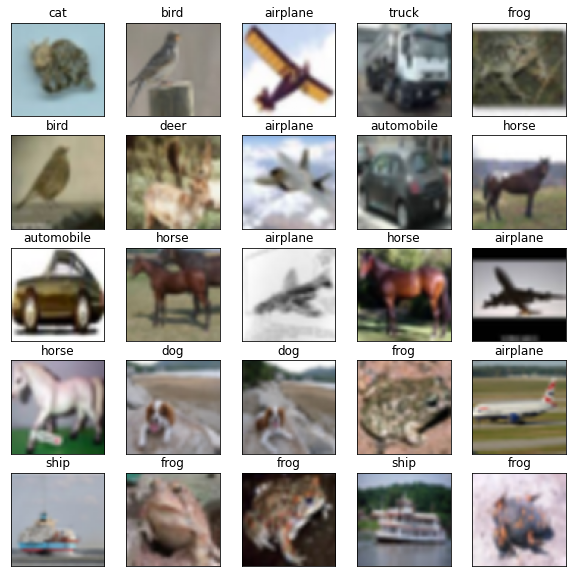

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

plot_images(images,labels,25)

In [8]:
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
  def forward(self, input, size=1024):
    return input.view(input.size(0), size, 1, 1)

In [9]:
class ConvVAE(nn.Module):
  def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
    super(ConvVAE, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=4, stride=2),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=4, stride=2),
      nn.ReLU(),
      nn.Conv2d(128, 256, kernel_size=4, stride=2),
      nn.ReLU(),
      Flatten()
    )     
      
    self.fc1 = nn.Linear(h_dim, z_dim)
    self.fc2 = nn.Linear(h_dim, z_dim)
    self.fc3 = nn.Linear(z_dim, h_dim)
      
    self.decoder = nn.Sequential(
      UnFlatten(),
      nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
      nn.ReLU(),
      nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
      nn.ReLU(),
      nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
      nn.ReLU(),
      nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
      nn.Sigmoid(),
    )    

  def reparameterize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    # return torch.normal(mu, std)
    esp = torch.randn(*mu.size())
    esp = esp.to(device)
    z = mu + std * esp
    return z
    
  def bottleneck(self, h):
    mu, logvar = self.fc1(h), self.fc2(h)
    z = self.reparameterize(mu, logvar)
    return z, mu, logvar

  def encode(self, x):
    h = self.encoder(x)
    z, mu, logvar = self.bottleneck(h)
    return z, mu, logvar

  def decode(self, z):
    z = self.fc3(z)
    z = self.decoder(z)
    return z

  def forward(self, x):
    z, mu, logvar = self.encode(x)
    z = self.decode(z)
    return z, mu, logvar

model = ConvVAE()
model.cuda(device)
print(model)


ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_fn(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
  # BCE = F.mse_loss(recon_x, x, size_average=False)

  # see Appendix B from VAE paper:
  # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

  return BCE + KLD, BCE, KLD

Epoch: 100 Training Loss: 28763872527.360


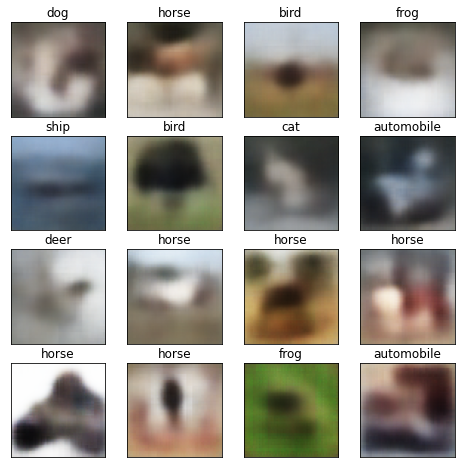

In [11]:
for epoch in range(epochs):    
    train_loss = 0.0    
    for data in train_loader:        
        images, labels = data        
        optimizer.zero_grad()  
        images = images.to(device)
        generated, mu, logvar = model(images)
        loss, bce, kld = loss_fn(generated, images, mu, logvar) 
        loss.backward()        
        optimizer.step()
        train_loss += loss.item()*images.size(0)
            
    train_loss = train_loss/len(train_loader)
    clear_output()
    print(f'Epoch: {epoch+1} Training Loss: {train_loss:.3f}')    
    plot_images(generated.cpu().data,labels,16)   
    

Original images


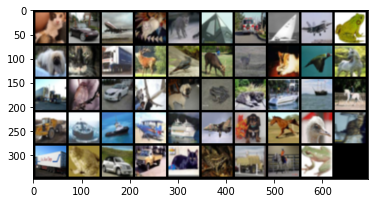

VAE reconstruction:


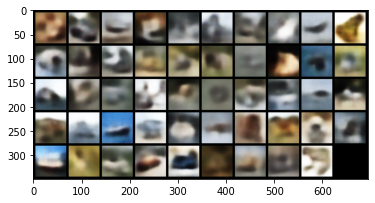

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):
    with torch.no_grad():    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(train_loader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10, 5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, model)

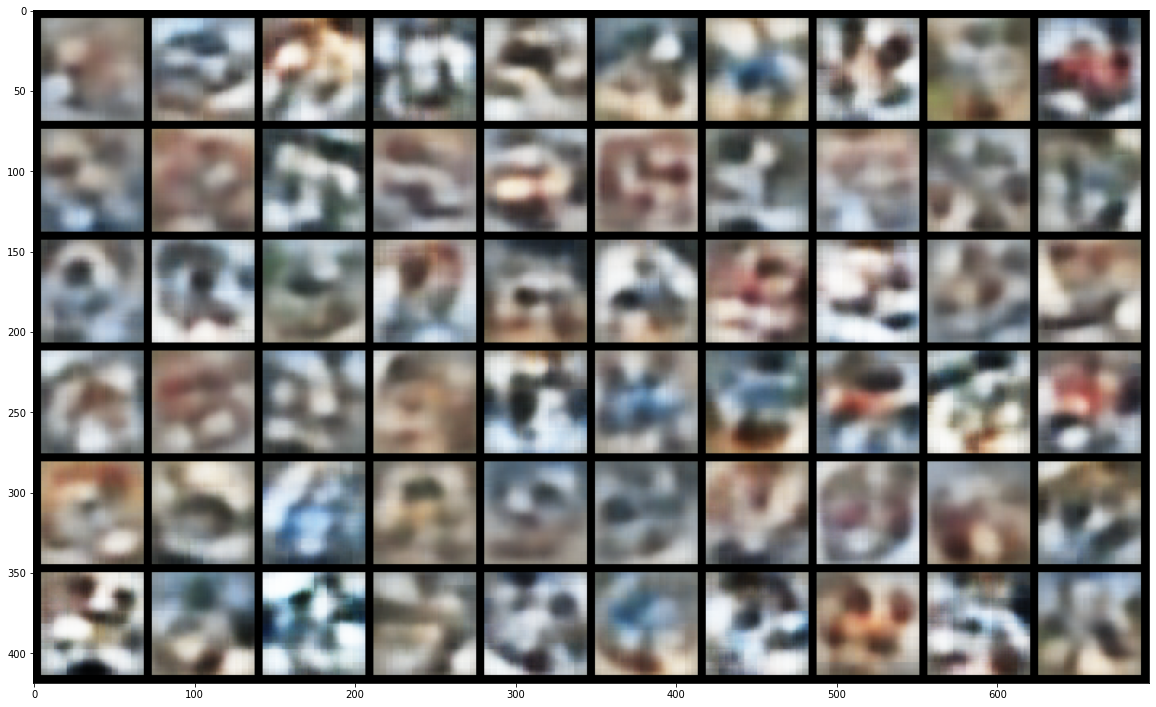

In [27]:
with torch.no_grad():
    # sample latent vectors from the normal distribution
    latent = torch.randn(60, 1024, device=device)
    # reconstruct images from the latent vectors
    img_recon = model.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 20))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

-2 0.25


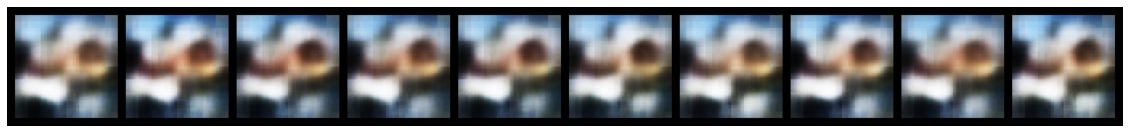

-1 0.25


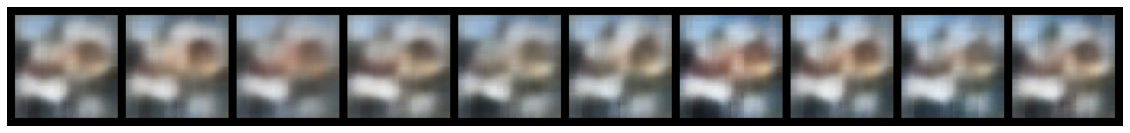

0 0.25


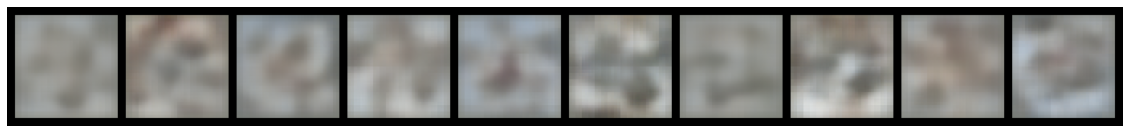

1 0.25


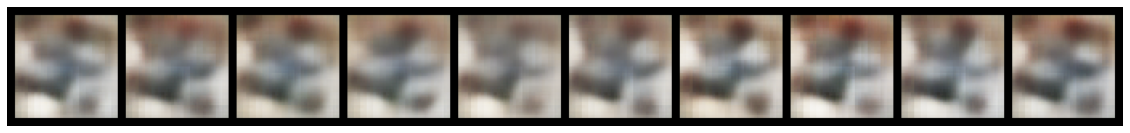

-2 0.5


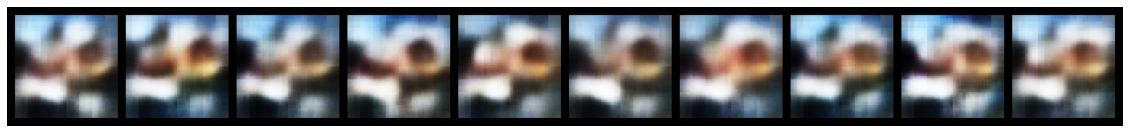

-1 0.5


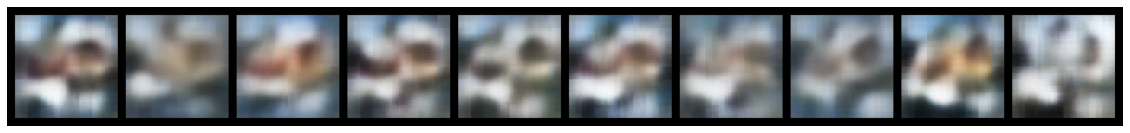

0 0.5


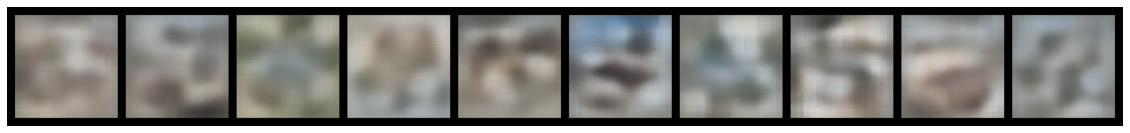

1 0.5


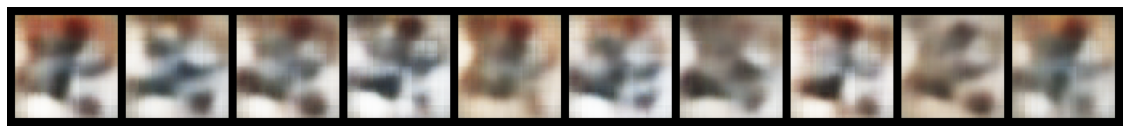

-2 0.75


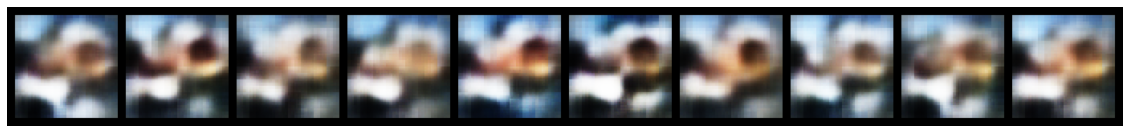

-1 0.75


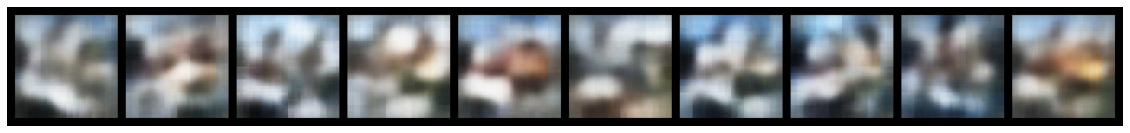

0 0.75


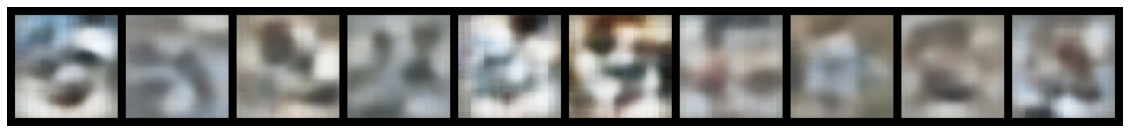

1 0.75


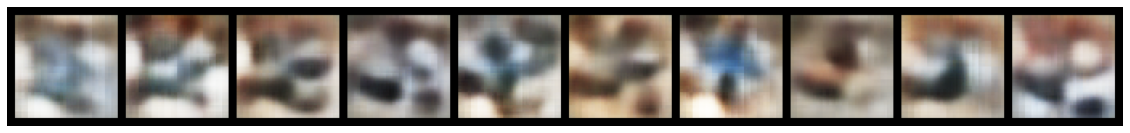

-2 1.0


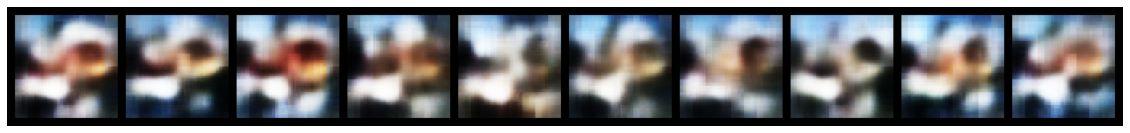

-1 1.0


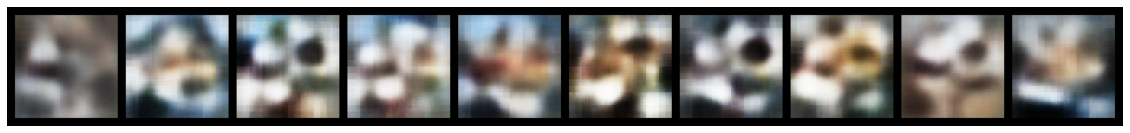

0 1.0


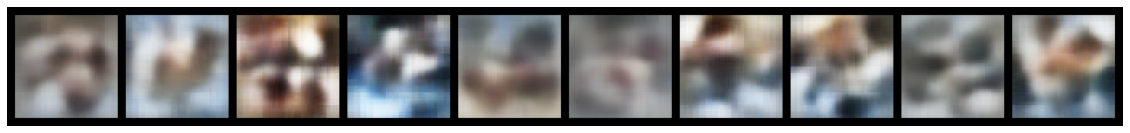

1 1.0


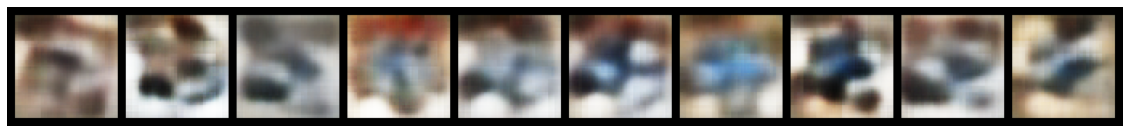

-2 1.25


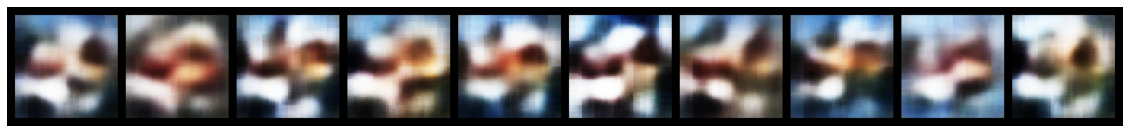

-1 1.25


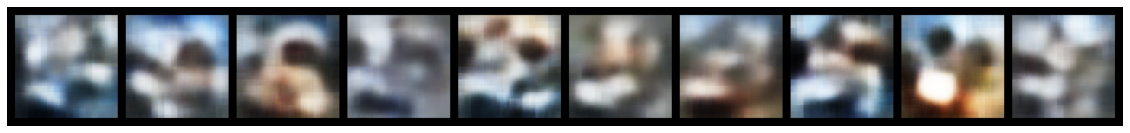

0 1.25


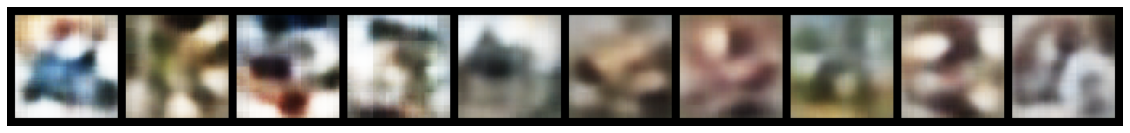

1 1.25


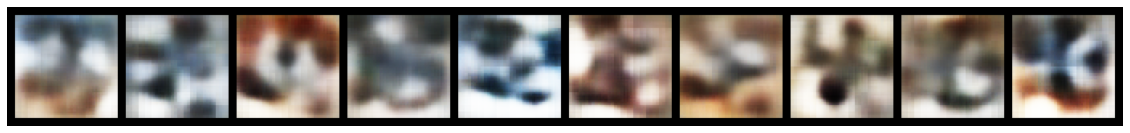

-2 1.5


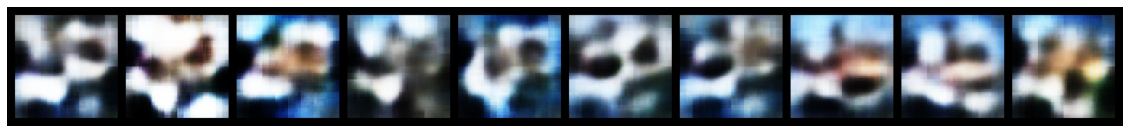

-1 1.5


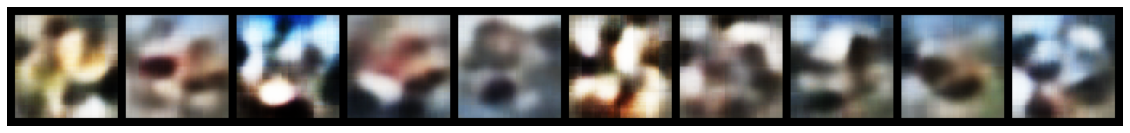

0 1.5


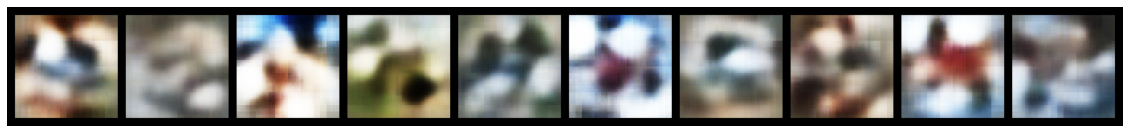

1 1.5


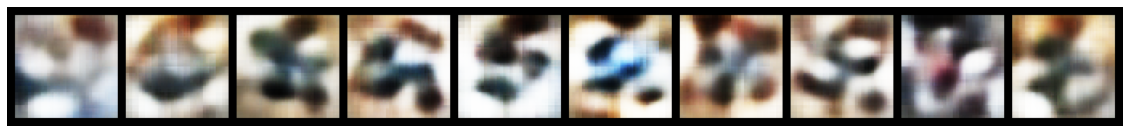

-2 1.75


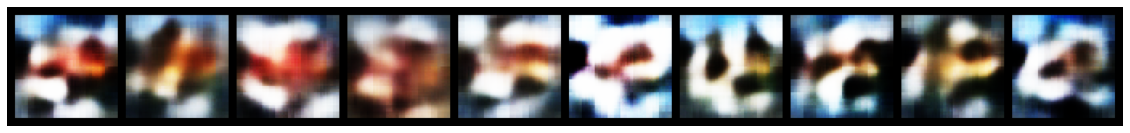

-1 1.75


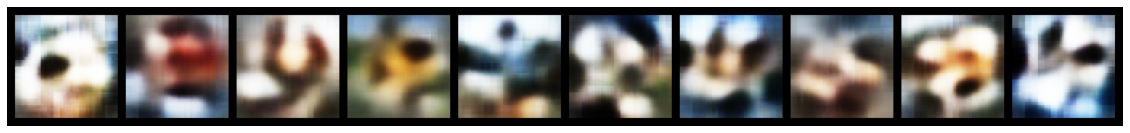

0 1.75


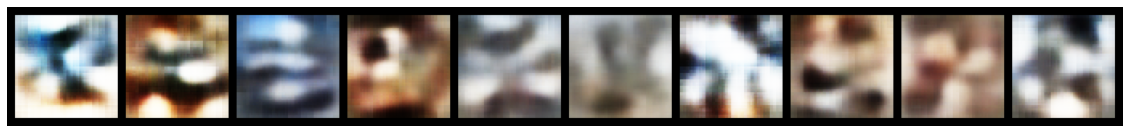

1 1.75


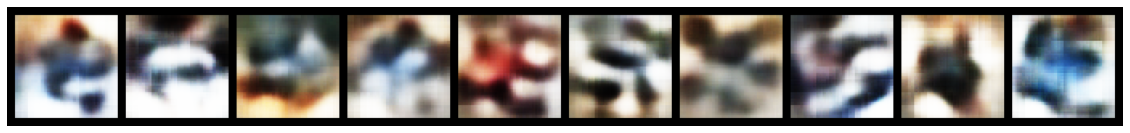

In [46]:
for std in np.arange(.25, 2, .25):
  for mean in np.arange(-2, 2, 1):
    with torch.no_grad():
        # sample latent vectors from the normal distribution
        latent = torch.normal(mean, std, size=(10, 1024), device=device)
        # reconstruct images from the latent vectors
        img_recon = model.decoder(latent)
        img_recon = img_recon.cpu()

        fig, ax = plt.subplots(figsize=(20, 20))
        show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
        ax.axis('off') 
        print(mean, std)
        plt.show()